In [1]:
import os
import xarray as xr

from dask import delayed, compute
from tqdm.notebook import tqdm

In [2]:
os.environ['http_proxy'] = '10.72.2.7:18080'
os.environ['https_proxy'] = '10.72.2.7:18080'

In [3]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:33582 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 16.00 GiB


In [4]:
client.cluster

In [5]:
def compute_pm_and_resample(ds):
    """Compute PM2.5 from other features in the M2T1NXAER product. If the product is not, just return the dataframe
    
    PM2.5 formula taken from this paper:
        Buchard, V., and Coauthors, 2016: Evaluation of the surface PM2.5 in Version 1 of the NASA MERRA Aerosol Reanalysis over the United States. 
        Atmospheric Environment, 125, 100–111, https://doi.org/10.1016/j.atmosenv.2015.11.004.
    """
    if 'DUSMASS25' in list(ds.data_vars):
        ds['PM2.5'] = ds['DUSMASS25'] + ds['SSSMASS25'] + ds['BCSMASS'] + 1.4 * ds['OCSMASS'] + 1.375 * ds['SO4SMASS']
    ds = ds.resample(time="1d").mean()
    return ds

def average_monthly_values(product, files):
    directory = os.path.join(product, 'averages')
    if not os.path.exists(directory):
        os.mkdir(directory)
            
    pbar = tqdm(files)
    for file in pbar:
        pbar.set_description(f'{file}')
        
        ds = xr.open_mfdataset(file, 
                               preprocess=compute_pm_and_resample, 
                               parallel=True)
    
        fname = f"{ds.time[0].values.astype('datetime64[M]').astype('str')}.nc4"
        path = os.path.join(directory, fname)
        ds.to_netcdf(path)
        ds.close()

In [6]:
import glob

def get_files(product):
    return [sorted(glob.glob(os.path.join(product, f'*{year}{month:02d}[0-9]*.nc4')))
             for year in range(2010, 2021) 
             for month in range(1, 13)]

In [ ]:
average_monthly_values('M2I1NXASM', get_files('M2I1NXASM'))

  0%|          | 0/132 [00:00<?, ?it/s]

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [ ]:
average_monthly_values('M2I3NXGAS', get_files('M2I3NXGAS'))

In [ ]:
average_monthly_values('M2SDNXSLV', get_files('M2SDNXSLV'))

In [ ]:
average_monthly_values('M2T1NXAER', get_files('M2T1NXAER'))

In [ ]:
average_monthly_values('M2T1NXRAD', get_files('M2T1NXRAD'))

In [ ]:
def combine_monthly_products(product):
    files = [os.path.join(product, 'averages', f'{year}-{month:02d}.nc4') for year in range(2010, 2021) for month in range(1, 13)]
    
    ds = xr.open_mfdataset(files, parallel=True)
    path = os.path.join(product, 'averages', f'{product}-all-years-daily-averages.nc4')
    ds.to_netcdf(path)
    ds.close()

In [ ]:
products = ['M2I1NXASM','M2I3NXGAS','M2SDNXSLV','M2T1NXAER','M2T1NXRAD']
pbar = tqdm(products)
for product in pbar:
    pbar.set_description(f'Processing {product}')
    combine_monthly_products(product)

In [17]:
files = [f'{product}/averages/{product}-all-years-daily-averages.nc4' for product in products]
ds = xr.open_mfdataset(files, compat='override')
ds.to_netcdf("merged-all-products-daily-averages.nc4")

In [18]:
ds.close()

In [19]:
ds = xr.open_dataset("merged-all-products-daily-averages.nc4")
ds

<xarray.Dataset>
Dimensions:      (lat: 22, lon: 22, time: 4018)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.9 -106.2 -105.6 ... -95.0 -94.38 -93.75
Data variables: (12/117)
    LWGAB        (time, lat, lon) float32 ...
    CLDTOT       (time, lat, lon) float32 ...
    ALBNIRDF     (time, lat, lon) float32 ...
    SWTDN        (time, lat, lon) float32 ...
    EMIS         (time, lat, lon) float32 ...
    LWTUPCLRCLN  (time, lat, lon) float32 ...
    ...           ...
    QV10M        (time, lat, lon) float32 ...
    HOURNORAIN   (time, lat, lon) float32 ...
    T2MMAX       (time, lat, lon) float32 ...
    T2MMEAN      (time, lat, lon) float32 ...
    T2MMIN       (time, lat, lon) float32 ...
    TPRECMAX     (time, lat, lon) float32 ...

In [24]:
ds['PM2.5'] *= 1e9

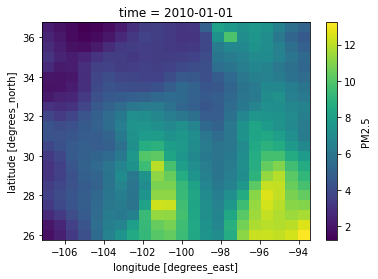

In [25]:
ds['PM2.5'][0].plot()

In [ ]:
client.close()